# Distributional Counterfactual Explanation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read and Process Data

In [2]:
df_ = pd.read_csv('data/hotel_booking/hotel_bookings.csv')
df = df_.copy()
target_name = 'is_canceled'
target = df[target_name]

In [4]:
# Initialize a label encoder
label_encoder = LabelEncoder()
label_mappings = {}


# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if df[column].dtype == 'object':
        # Handle missing values by filling with a placeholder and then encoding
        df[column] = df[column].fillna('Unknown')
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))


# For columns with NaN values that are numerical, we will impute them with the median of the column
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)

# Display the first few rows of the transformed dataframe
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,1,0,342,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,14.0,179.0,0,2,0.0,0,0,1,15
1,1,0,737,2015,5,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,14.0,179.0,0,2,0.0,0,0,1,15
2,1,0,7,2015,5,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,14.0,179.0,0,2,75.0,0,0,1,46
3,1,0,13,2015,5,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,179.0,0,2,75.0,0,0,1,46
4,1,0,14,2015,5,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,179.0,0,2,98.0,0,1,1,76


## Model Training

In [5]:
features = [
    # 'hotel', 
    'lead_time', 
    # 'arrival_date_year', 
    # 'arrival_date_month',
    # 'arrival_date_week_number', 
    # 'arrival_date_day_of_month',
    # 'stays_in_weekend_nights', 
    # 'stays_in_week_nights', 
    # 'adults', 
    # 'children',
    # 'babies', 
    # 'meal', 
    # 'country', 
    # 'market_segment', 
    # 'distribution_channel',
    # 'is_repeated_guest', 
    # 'previous_cancellations',
    # 'previous_bookings_not_canceled', 
    # 'reserved_room_type',
    # 'assigned_room_type', 
    'booking_changes', 
    # 'deposit_type', 
    # 'agent',
    # 'company', 
    # 'days_in_waiting_list', 
    # 'customer_type', 
    # 'adr',
    # 'required_car_parking_spaces', 
    # 'total_of_special_requests'
]

df_X = df[features].copy()
df_y = target

In [6]:
seed = 42

np.random.seed(seed)  # for reproducibility


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=seed)

std = X_train.std()
mean = X_train.mean()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Initialize the model, loss function, and optimizer
model = BlackBoxModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.6767736077308655

## Counterfactual Explanation

In [117]:
sample_num = 100
delta = 0.1
alpha = 0.05
N=10

indice = (X_test.sample(sample_num)).index

X = X_test.loc[indice].values
y = model(torch.FloatTensor(X))

y_target = torch.distributions.beta.Beta(0.1, 0.9).sample((sample_num,))

y_true = y_test.loc[indice]

In [148]:
from explainers.dce import DistributionalCounterfactualExplainer

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    X=X, 
    y_target=y_target, 
    lr=1e-1, 
    n_proj=N,
    delta=delta)

DEBUG:root:test


In [149]:
np.sqrt(explainer.wd.distance(y, y_target, delta=delta)[0].item())

0.36825865888677367

In [150]:
explainer.wd.distance_interval(y, y_target, delta=delta, alpha=0.10)

(0.3215083385634991, 0.40853059127364666)

In [179]:
explainer.optimize_without_chance_constraints(max_iter=20, tau=1e3)

DEBUG:root:test
INFO:root:Optimization (without chance constraints) started
INFO:root:Iter 1: Q = 3.825778007507324, term1 = 381.343017578125, term2 = 0.012472661212086678
INFO:root:Iter 2: Q = 3.2968132495880127, term1 = 328.56719970703125, term2 = 0.011253931559622288
INFO:root:Iter 3: Q = 2.842594623565674, term1 = 283.14825439453125, term2 = 0.01122436486184597
INFO:root:Iter 4: Q = 2.4490442276000977, term1 = 243.79922485351562, term2 = 0.011163745075464249
INFO:root:Iter 5: Q = 2.1086668968200684, term1 = 209.77108764648438, term2 = 0.011066610924899578
INFO:root:Iter 6: Q = 1.8165595531463623, term1 = 180.5762481689453, term2 = 0.010906151495873928
INFO:root:Iter 7: Q = 1.565079689025879, term1 = 155.453369140625, term2 = 0.010652564465999603
INFO:root:Iter 8: Q = 1.348131537437439, term1 = 133.81661987304688, term2 = 0.010066074319183826
INFO:root:Iter 9: Q = 1.1609786748886108, term1 = 115.1798095703125, term2 = 0.009273304603993893
INFO:root:Iter 10: Q = 0.9997420907020569, t

In [180]:
X_s = explainer.X.clone()
X_t = explainer.X_prime.clone()

In [181]:
np.sqrt(explainer.swd.distance(X_s, X_t, delta)[0].item())

5.2815060525252955

In [182]:
explainer.swd.distance_interval(X_s, X_t, delta=delta, alpha=alpha)

c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:303: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x.clone()
c:\Users\leiyo\GitHub\distributional-counterfactual-explanation\explainers\distances.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = y.clone()


(0.0, 5.90132382137229)

In [183]:
factual_X = df[df_X.columns].loc[indice].copy()
counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy() * std[df_X.columns].values + mean[df_X.columns].values, columns=df_X.columns)
# counterfactual_X = pd.DataFrame(explainer.best_X.detach().numpy(), columns=df_X.columns)

factual_y = pd.DataFrame(y.detach().numpy(),columns=[target_name], index=factual_X.index)
counterfactual_y = pd.DataFrame(explainer.best_y.detach().numpy(),columns=[target_name], index=factual_X.index)

In [184]:
pd.DataFrame({
    'factual_y': factual_y[target_name].values,
    'counterfactual_y': counterfactual_y[target_name].values,
})

,factual_y,counterfactual_y
0,0.418274,0.026873
1,0.492623,0.431523
2,0.331205,0.263249
3,0.485512,0.408215
4,0.428104,0.127436
...,...,...
95,0.442847,0.343395
96,0.444758,0.296818
97,0.149337,0.125696
98,0.438555,0.281529


In [185]:
counterfactual_X.index = factual_X.index
counterfactual_X[target_name] = counterfactual_y

In [186]:
factual_X[target_name] = factual_y

In [187]:
counterfactual_X

,lead_time,booking_changes,is_canceled
15617,-56.647760,0.148746,0.026873
92316,136.521535,0.267514,0.431523
40634,16.850025,-0.130766,0.263249
81127,117.164650,0.271887,0.408215
90878,-4.574228,0.034314,0.127436
...,...,...,...
16261,56.597066,0.248242,0.343395
22819,52.172772,0.369949,0.296818
91590,-20.751427,-0.719166,0.125696
43000,43.038428,0.383606,0.281529


In [188]:
check_column = 'lead_time'
pd.DataFrame({
    'factual': factual_X[check_column].values, 
    'counterfactual': counterfactual_X[check_column].values
    })

,factual,counterfactual
0,48,-56.647760
1,158,136.521535
2,28,16.850025
3,146,117.164650
4,57,-4.574228
...,...,...
95,77,56.597066
96,81,52.172772
97,0,-20.751427
98,68,43.038428


In [189]:
factual_X[check_column].mean()

94.24

In [190]:
counterfactual_X[check_column].mean()

62.3841998124943

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001B5DC859EE0>


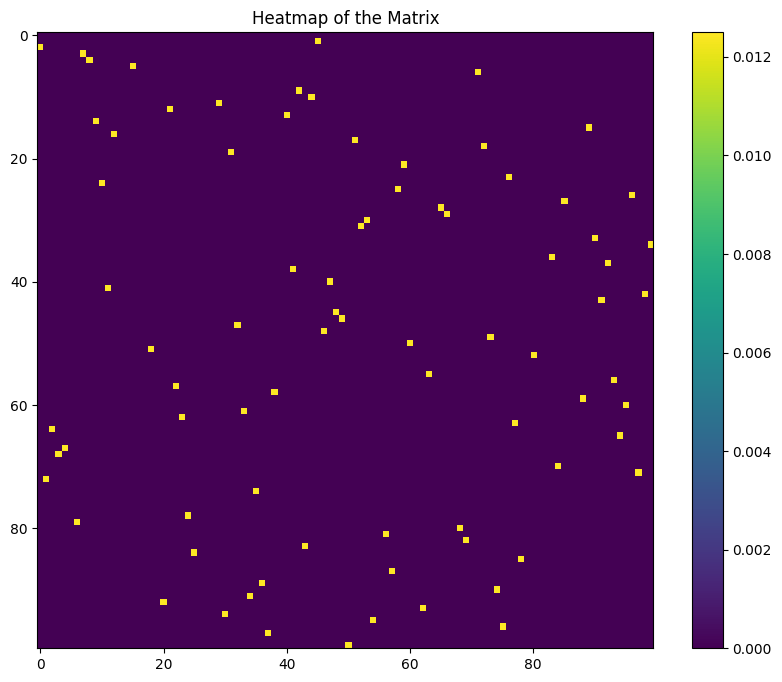

In [191]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix for demonstration
matrix = explainer.wd.nu.numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()
